## Simulation code

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from tqdm import tqdm

class DBM_RDG:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 debug=False,
                 threshold = 0.0001,
                 dim_info=False):

        # Unless specified, expect grid of NxNxN dimension, in order z, x, y
        if dimensions is None:
            self.dim = {'height': N, 'width': N,'depth': N}
        else:
            self.dim = {'height': dimensions[0], 'width': dimensions[1],'depth': dimensions[2]}

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  anything else encodes fixed potential
        # (I also use this grid to track order of cells in lightning structure)
        self.fixed_grid = np.zeros(shape=list(self.dim.values()))
        
        # Calculate effective width and depth given inputted dimensions
        effective_width = self.dim['height']//2+1
        y_pos_cells = self.dim['width']*2//3
        effective_depth = y_pos_cells * np.sqrt(3)/2
        diff = int(effective_depth - effective_width)
        effective_width += diff
       
        if dim_info:
            print("(y-pos cells):", y_pos_cells)
            print("Effective depth (y-pos):", effective_depth)
            print("Effective width (x-pos):", effective_width)
            print("Effective height (z-pos):", (self.dim['depth']-1)*np.sqrt(6)/3)
        
        
        self.upwards_neighbors = [(0,0,1),(0,1,1),(1,1,1)]
        
        # Set all boundaries to be fixed
        
        # top & bottom boundary
        for x_pos in range(effective_width):
            for y_pos in range(y_pos_cells):
                self.fixed_grid[x_pos+y_pos//2, y_pos, 0] = -1
                try:
                    self.fixed_grid[x_pos+y_pos//2 + effective_width//6, y_pos + effective_width//3+1, self.dim['depth']-1] = -1
                except:
                    ...
        
        # right boundary
        y_pos = 0
        current_pos = [0,0,0]
        while y_pos < self.dim['width']*2//3:
            current_pos = [y_pos//2, y_pos, 0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            y_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['depth']:
                try:
                    self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                except:
                    ...
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            
        # left boundary
        y_pos = 0
        while y_pos < self.dim['width']*2//3:
            current_pos = [(self.dim['height']*3//6)+y_pos//2+1+diff, y_pos, 0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            y_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['depth']:
                try:
                    self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                except:
                    ...
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            
        # front boundary
        x_pos = 0
        while x_pos < effective_width+1: #(self.dim['height']//2+2):
            current_pos = [x_pos, 0, 0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            x_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['depth']:
                self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            
        # back boundary
        x_pos = 0
        while x_pos < effective_width+1: #(self.dim['height']//2+2):
            current_pos = [self.dim['height']*5//6-x_pos+1+diff,self.dim['width']*2//3,0]
            self.fixed_grid[current_pos[0], current_pos[1], current_pos[2]] = -1
            x_pos += 1
            
            z_pos = 0
            current_z_pos = np.array(current_pos[:])
            while z_pos < self.dim['depth']:
                try:
                    self.fixed_grid[current_z_pos[0], current_z_pos[1], current_z_pos[2]] = -1
                except:
                    ...
                current_z_pos += np.array(self.upwards_neighbors[z_pos%3])
                z_pos += 1
            

        # The electric potential
        self.potential = np.zeros(shape=list(self.dim.values()))

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 1

        # To debug or not
        self.debug = debug

        # Keep track of current neighbors of structure
        self.structure_neighbors = set()

        self.struck_ground = False

        self.threshold = threshold

        # Debugging lists
        self.difference_per_conv = []
        self.overall_sum = []
        
        self.structure_history = []
        
        self.dist_to_ground = self.dim['depth']

        # RDG Neighborhood
        self.neighbors = [(0,0,0), (0,1,0), (0,-1,0), (1,0,0), (1,1,0), (-1,0,0), (-1,-1,0),
                                      (0,0,1),(0,1,1),(1,1,1), 
                                      (0,0,-1),(0,-1,-1),(-1,-1,-1)]
        
        # Setup initial electric potential
        self.initial_electric_pot()

        # Add the first cell as a structure neighbor
        self.structure_neighbors.add((effective_width//2 + y_pos_cells//4, y_pos_cells//2, 0))
        
        # Update structure with that cell
        self.expand_lightning_to((effective_width//2 + y_pos_cells//4, y_pos_cells//2, 0))
        
        self.steps += 1
               
    # Could remove this
    def get_neighbors(self, pos):
        
        neighbors = []
        
        for neighbor_rel in self.neighbors:
            neighbors.append((pos[0]+neighbor_rel[0], pos[1]+neighbor_rel[1], pos[2]+neighbor_rel[2]))

        
        return neighbors


    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.dim['depth'], desc="How close the lightning is to the ground", unit="iter")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.dim['depth'] - self.newest_neighbor[2] < self.dist_to_ground:
                    self.dist_to_ground = self.dim['depth'] - self.newest_neighbor[2]
                    progress_bar.update(1)

    def update(self):

        weights = []
        # For each structure neighbor
        for neighbor_pos in self.structure_neighbors:
            # Raise each weight to the power of nu
            weights.append(self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] ** self.nu)
        
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(self.structure_neighbors), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.expand_lightning_to(chosen_cell)

        self.steps += 1

    def initial_electric_pot(self):
        # Create a linear gradient along the depth axis
        gradient = np.linspace(0, 1, self.dim['depth'])[np.newaxis, np.newaxis, :]
        #gradient = np.linspace(0, 0, self.dim['height'])[:, np.newaxis, np.newaxis]

        # Apply the gradient to the array
        self.potential += gradient


    def expand_lightning_to(self, pos):
        '''
        Updates correpsonding grids
        Update neighborhood of lightning structure
        Call method to update electric potential
        '''

        self.newest_neighbor = pos
        
        self.structure_history.append(pos)

        # Remove the potential
        self.potential[pos[0], pos[1], pos[2]] = 0
        #self.potential[pos[0], pos[1], pos[2]] = 1

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1], pos[2]] = self.steps

        # Update structure neighbors
        self.structure_neighbors.remove(pos)
        for neighbor_pos in self.get_neighbors(pos):
            if neighbor_pos[2] == self.dim['depth']:
                self.struck_ground = True
                break

            if neighbor_pos[0] >= 0 and neighbor_pos[0] < self.dim['height'] and \
                neighbor_pos[1] >= 0 and neighbor_pos[1] < self.dim['width'] and \
                neighbor_pos[2] >= 0 and neighbor_pos[2] < self.dim['depth'] and \
                self.potential[neighbor_pos[0], neighbor_pos[1], neighbor_pos[2]] != 0:
                    self.structure_neighbors.add(neighbor_pos)

        if not self.struck_ground:
            # Update the rest of the potential
            self.potential = self.update_electric_potential()


    def update_electric_potential(self):
        '''
        Uses iterative diffusion to estimate solution to Laplace equation.
        Tracks percentual change for each cell after each diffusion, 
        terminates when the largest percentual change is less than threshold
        '''

        # Make ground and lightning structure fixed
        no_change_mask = self.fixed_grid != 0


        old_potential = np.copy(self.potential)
        new_potential = np.copy(old_potential)

        itr = 0
        # Until threshold
        while True:

            neighbor_avgs = np.zeros_like(new_potential)
            
            # Set each cell to the average in each direction from self.neighbors
            for neighbor in self.neighbors:
                neighbor_avgs += np.roll(new_potential, neighbor, axis=(0,1,2))
            # Divide by the number of neighbors
            neighbor_avgs /= len(self.neighbors)

            new_potential = neighbor_avgs

            # Reset the cells that shouldn't change
            new_potential[no_change_mask] = self.potential[no_change_mask]

            if self.debug:
                self.difference_per_conv.append(np.sum(abs(np.array(new_potential) - np.array(old_potential))))
                self.overall_sum.append(np.sum(np.array(new_potential)))
            
            # percentual change relative to previous iteration
            rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)

            # Terminate when max percentual change is small (below threshold)
            if np.nanmax(rel_differences) < self.threshold:
                break

            old_potential = np.copy(new_potential)
            
        return new_potential

In [5]:
width=30
height=20
nu=6
threshold=0.005
sim_instance = DBM_RDG(dimensions=(width, width, height), nu=nu, threshold=threshold)
sim_instance.strike_lightning()

C:\Users\gabri\AppData\Local\Temp/ipykernel_24492/596232392.py:294: RuntimeWarning: divide by zero encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)
C:\Users\gabri\AppData\Local\Temp/ipykernel_24492/596232392.py:294: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


In [6]:
import cProfile
width=20
height=20
nu=6
threshold=0.001
sim_instance = DBM_RDG(dimensions=(width, width, height), nu=nu, threshold=threshold)
cProfile.run("sim_instance.strike_lightning()")

C:\Users\gabri\AppData\Local\Temp/ipykernel_24492/596232392.py:294: RuntimeWarning: divide by zero encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)
C:\Users\gabri\AppData\Local\Temp/ipykernel_24492/596232392.py:294: RuntimeWarning: invalid value encountered in divide
  rel_differences = abs(np.array(new_potential) - np.array(old_potential))/np.array(old_potential)


         111841 function calls in 0.397 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       28    0.000    0.000    0.000    0.000 596232392.py:167(get_neighbors)
        1    0.000    0.000    0.397    0.397 596232392.py:178(strike_lightning)
       28    0.002    0.000    0.397    0.014 596232392.py:197(update)
       28    0.001    0.000    0.394    0.014 596232392.py:222(expand_lightning_to)
       27    0.111    0.004    0.393    0.015 596232392.py:258(update_electric_potential)
        1    0.000    0.000    0.397    0.397 <string>:1(<module>)
      670    0.001    0.000    0.004    0.000 _methods.py:55(_any)
      697    0.000    0.000    0.000    0.000 function_base.py:869(_copy_dispatcher)
      697    0.000    0.000    0.004    0.000 function_base.py:873(copy)
      670    0.000    0.000    0.000    0.000 multiarray.py:1080(copyto)
     9380    0.002    0.000    0.002    0.000 multiarray.py:85(empty_like)
     

## Gather data

In [7]:
width = 90
height = 32
nu=6
threshold=0.001

filename_viz = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_hex_int\\{width}x{width}x{height}_{nu}_{threshold}_vizdata.txt"
filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_hex_int\\{width}x{width}x{height}_{nu}_{threshold}_strikedata.txt"
filename_volume = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_hex_int\\{width}x{width}x{height}_{nu}_{threshold}_volumedata.txt"
viz_file = open(filename_viz,'a')
strike_file = open(filename_strike,'a')
volume_file = open(filename_volume,'a')

viz_storing_freq = 1000

i = 0
while True:
    sim_instance = DBM_RDG(dimensions=(width, width, height), nu=nu, threshold=threshold)
    sim_instance.strike_lightning()

    i += 1

    if i % viz_storing_freq == 0:
        for pos in sim_instance.structure_history:
            viz_file.write(f"{pos}.")
        viz_file.write('#')
        print()

    strike_file.write(f"{sim_instance.newest_neighbor}#")
    volume_file.write(f"{len(sim_instance.structure_history)}#")
    
    print('*', end='')


In [11]:
viz_file.close()
strike_file.close()
volume_file.close()

## Strike location distribution

Datapoints: 1770


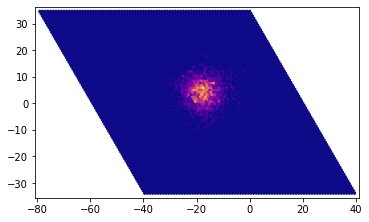

In [32]:
def float_to_rgb_color(value, cmap_name='viridis'):
    value = min(0.9999999999, max(0, value))
    
    cmap = plt.get_cmap(cmap_name)
    
    rgba = cmap(value)
    
    #hex_color = '#{:02x}{:02x}{:02x}'.format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255))
    return [rgba[0], rgba[1], rgba[2]]

import copy
from hexalattice.hexalattice import *
N=80
width=N
height=28
nu=6
threshold=0.001

filename_strike = f"C:\\Users\\gabri\\Desktop\\Capstone\\data\\RDG_hex_int\\{width}x{width}x{height}_{nu}_{threshold}_strikedata.txt"
strike_file = open(filename_strike,'r')
strike_data_str = strike_file.read()
strike_data_str = strike_data_str.split('#')[:-1]

strike_data = np.zeros((N, N))
print("Datapoints:", len(strike_data_str))

for point in strike_data_str:
    point = point.split(',')
    x_coord = point[0]
    y_coord = point[1]
    x_coord = x_coord.strip()
    x_coord = x_coord.strip('(')
    y_coord = y_coord.strip()
    y_coord = y_coord.strip(')')
    strike_data[int(x_coord), int(y_coord)] += 1
strike_data /= np.max(strike_data)

size = 30
hex_centers, _ = create_hex_grid(nx=N,
                                     ny=N,
                                     do_plot=False)
x_hex_coords = hex_centers[:, 0]
x_hex_coords = np.array([val - (i*1)//(N) + (i*1)//(2*N) for i, val in enumerate(x_hex_coords)])
#x_hex_coords = np.array([val + (i)//(N) for i, val in enumerate(x_hex_coords)])
y_hex_coords = hex_centers[:, 1]

colors = np.array([float_to_rgb_color(strike_data[x_pos, y_pos], cmap_name='plasma') for y_pos in range(N) for x_pos in range(N)])
edge_colors = copy.deepcopy(colors)

#y_pos = width-1
#for x_pos in range(width//2-1, width): 
#    colors[x_pos + y_pos*width] = [0, 0, 0]
#    edge_colors[x_pos + y_pos*width] = [1, 1, 1]
    
#y_pos = width*2//3
#for x_pos in range(width//6, width*4//6+1): 
    #colors[x_pos + y_pos//2 * width] = [0, 0, 0]
    #colors[x_pos  + y_pos//2 * width] = [0, 0, 0]
    #edge_colors[x_pos + y_pos//2 *width] = [1, 1, 1]


#x_pos = width-1
#for y_pos in range(width//3-1, width-1):
#    colors[x_pos + y_pos//2 + y_pos*width] = [0, 0, 0]
#    edge_colors[x_pos + y_pos//2 + y_pos*width] = [1, 1, 1]
    
#x_pos = -width//2-1
#for y_pos in range(width//3+1, width):
#    colors[x_pos + y_pos//2 + y_pos*width] = [0, 0, 0]
#    edge_colors[x_pos + y_pos//2 + y_pos*width] = [1, 1, 1]

h_ax = plot_single_lattice_custom_colors(x_hex_coords, y_hex_coords,
                                      face_color=colors,
                                      edge_color=edge_colors,
                                      min_diam=0.9,
                                      plotting_gap=0.01,
                                      rotate_deg=0)

plt.show()